# Analyzing Pseudomonas data generated with BacDrop -- Gene level



In [3]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import mudata as md

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/BacDrop"
data_all = md.read_h5mu(data_path + "/mudata_nSBM_hierarchy_2_final.h5mu")
data_all

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

### Select Pseudomonas data on gene level from the whole dataset

In [8]:
data_ps = (data_all["SC_genes"][data_all["SC_genes"].obs["strains"] == "GSM5456505_PsA_CDS"]).copy()
data_ps

AnnData object with n_obs × n_vars = 8192 × 14009
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

### Filter cells

--> filter baased on mean absolute standard deviation

In [188]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_ps, nmads=5, min_cells=2, min_genes=5)
print(data_ps.obs.outlier.value_counts())
print(f"Total number of cells: {data_ps.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    8129
True       63
Name: count, dtype: int64
Total number of cells: 8192
Number of cells after filtering: 1243


AnnData object with n_obs × n_vars = 1243 × 1138
    obs: 'strains', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

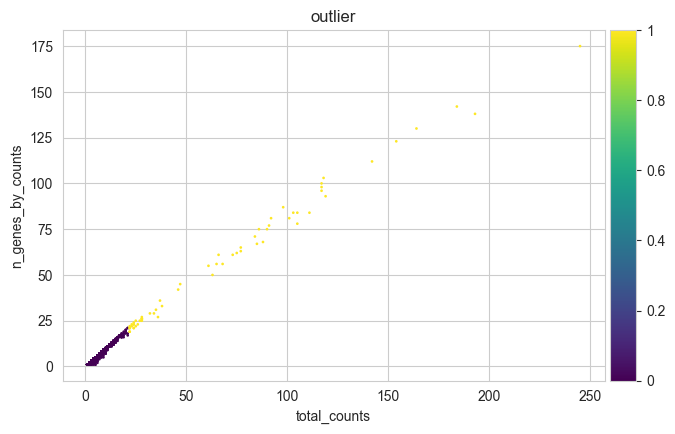

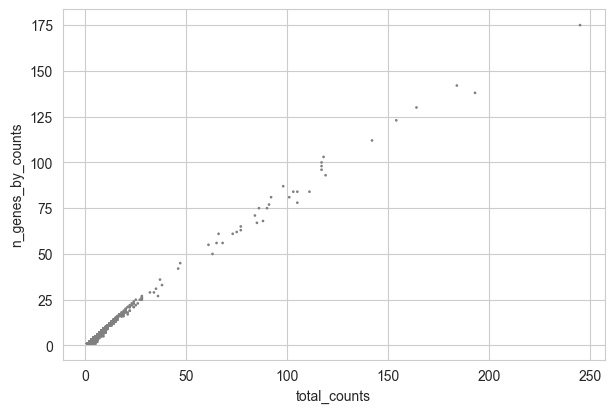

In [189]:
sc.pl.scatter(data_ps, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis")
plt.show()
sc.pl.scatter(data_ps, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly not overdispersed. Therefore, we will use sqrt transformation and Poisson count splitting

In [190]:
data_gene.layers["counts"] = data_gene.X.copy()

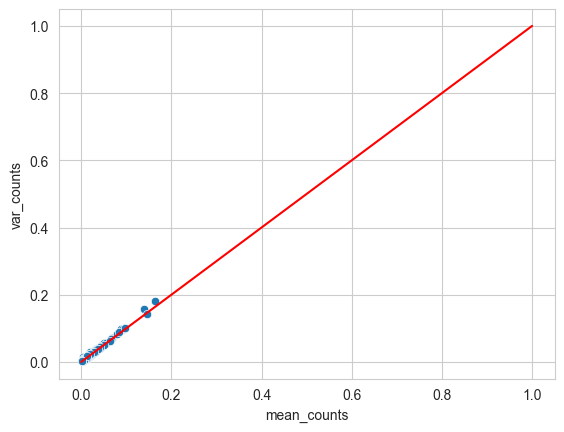

In [191]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.show()

In [192]:
print(data_gene.obs)

                                          strains  n_genes_by_counts  \
AACGTTCTGTCGACCCAGAGACGAATGTA  GSM5456505_PsA_CDS                  5   
AACGTTCTGTCGACCCGGAAACAAAGTAC  GSM5456505_PsA_CDS                  3   
AAGAAATGGAGGAAACAATGGAAGCTTTG  GSM5456505_PsA_CDS                  3   
AAGAAATGGAGGAAAGGTGCGACCTGCGA  GSM5456505_PsA_CDS                  5   
AAGAAATGGAGGAACACATCGAATCCTTT  GSM5456505_PsA_CDS                  5   
...                                           ...                ...   
TTCACCTGTCGGCTACGCCTTGTGATCAC  GSM5456505_PsA_CDS                  5   
TTCACCTGTCGGCTAGTACCGACCTCCTA  GSM5456505_PsA_CDS                  6   
TTCACCTGTCGGCTCCGAGCGACTTCACC  GSM5456505_PsA_CDS                  5   
TTCACCTGTCGGCTCGGGTCGACTTCACC  GSM5456505_PsA_CDS                  5   
TTCACCTGTCGGCTTCGACCACCGATTCA  GSM5456505_PsA_CDS                  6   

                               log1p_n_genes_by_counts  total_counts  \
AACGTTCTGTCGACCCAGAGACGAATGTA                 1.791759         

## Estimate negative binomial parameters for each gene

In [193]:
import tools.scTransform as sct
importlib.reload(sct)
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

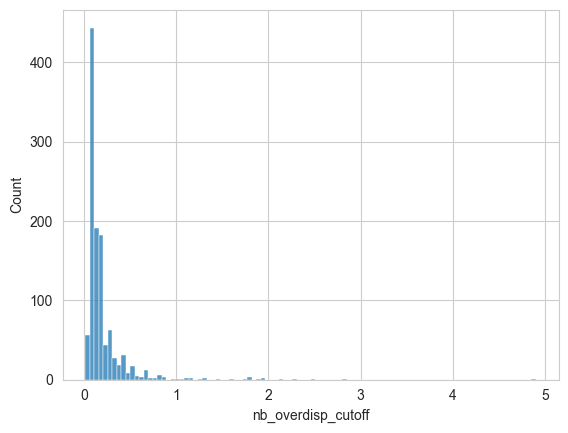

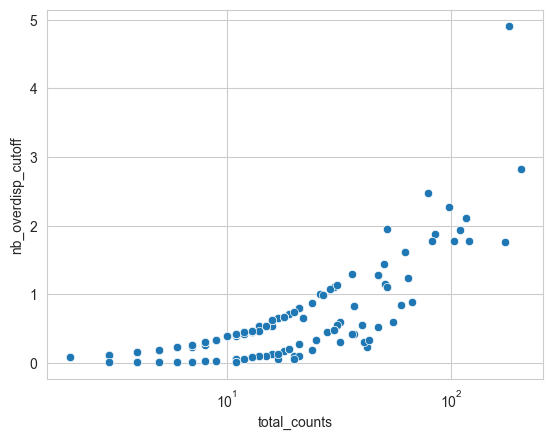

In [194]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="total_counts")
g.set(xscale="log")
plt.show()

In [195]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [196]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
print("Normalized")
print(data_gene.X[:, 363])
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
print("VST")
print(data_gene.X[:, 363])

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
print("scaled")
print(data_gene.X[:, 363])
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

Normalized
  (308, 0)	1.0
  (714, 0)	1.25
  (738, 0)	1.25
  (815, 0)	1.0
VST
  (0, 0)	-3.236506623456592
  (1, 0)	-3.236506623456592
  (2, 0)	-3.236506623456592
  (3, 0)	-3.236506623456592
  (4, 0)	-3.236506623456592
  (5, 0)	-3.236506623456592
  (6, 0)	-3.236506623456592
  (7, 0)	-3.236506623456592
  (8, 0)	-3.236506623456592
  (9, 0)	-3.236506623456592
  (10, 0)	-3.236506623456592
  (11, 0)	-3.236506623456592
  (12, 0)	-3.236506623456592
  (13, 0)	-3.236506623456592
  (14, 0)	-3.236506623456592
  (15, 0)	-3.236506623456592
  (16, 0)	-3.236506623456592
  (17, 0)	-3.236506623456592
  (18, 0)	-3.236506623456592
  (19, 0)	-3.236506623456592
  (20, 0)	-3.236506623456592
  (21, 0)	-3.236506623456592
  (22, 0)	-3.236506623456592
  (23, 0)	-3.236506623456592
  (24, 0)	-3.236506623456592
  :	:
  (1218, 0)	-3.236506623456592
  (1219, 0)	-3.236506623456592
  (1220, 0)	-3.236506623456592
  (1221, 0)	-3.236506623456592
  (1222, 0)	-3.236506623456592
  (1223, 0)	-3.236506623456592
  (1224, 0)	-3.2

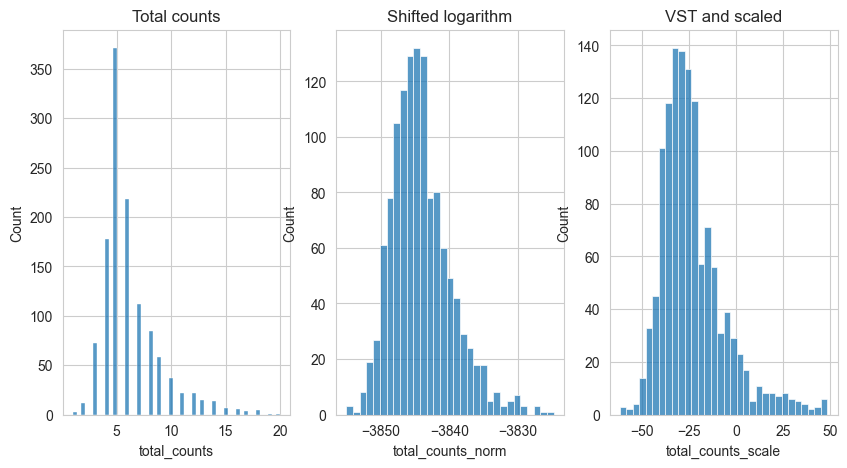

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.show()

## Count-splitting into train and test data

In [244]:
importlib.reload(cs)
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, min_cells=1, max_counts=1e9, seed=1234)


In [245]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
data_train.X = np.nan_to_num(data_train.X, nan=0)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
data_test.X = np.nan_to_num(data_test.X, nan=0)
sc.tl.pca(data_test, svd_solver='arpack')

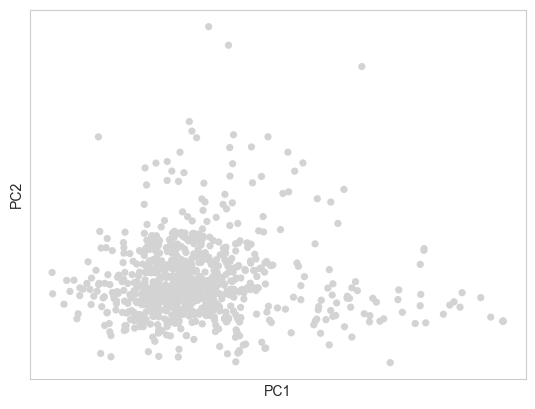

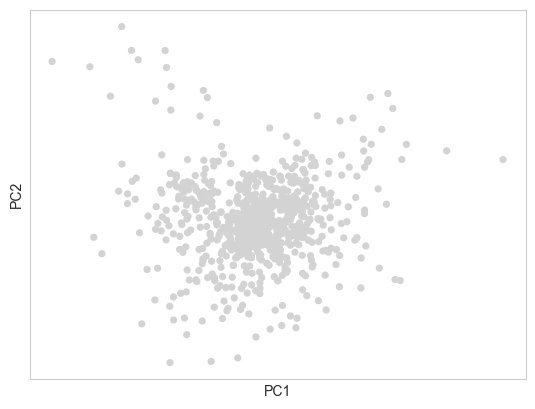

In [246]:
sc.pl.pca(data_train)
plt.show()

sc.pl.pca(data_test)
plt.show()

### Principal component selection

In [247]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:1


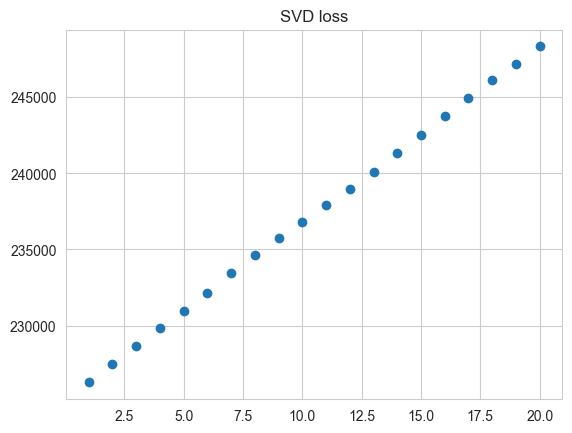

1 PCs seems to be the optimum


In [248]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.show()

print(f"{k_opt} PCs seems to be the optimum")

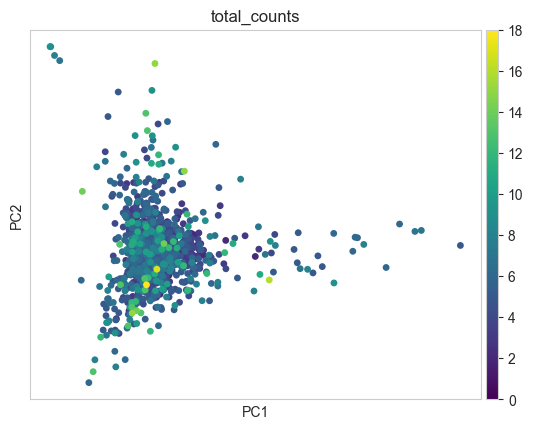

In [45]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis")
plt.show()

In [46]:
print(data_gene)

AnnData object with n_obs × n_vars = 1243 × 374
    obs: 'strains', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'mean', 'std'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [48]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="Pseudo_gene_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 45
Optimal min_dist: 0.1


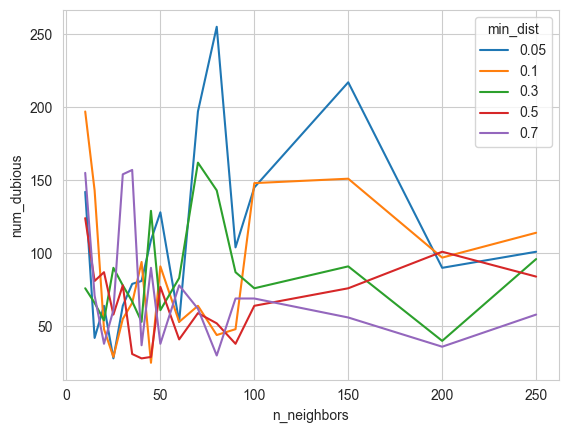

In [49]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.show()

In [50]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


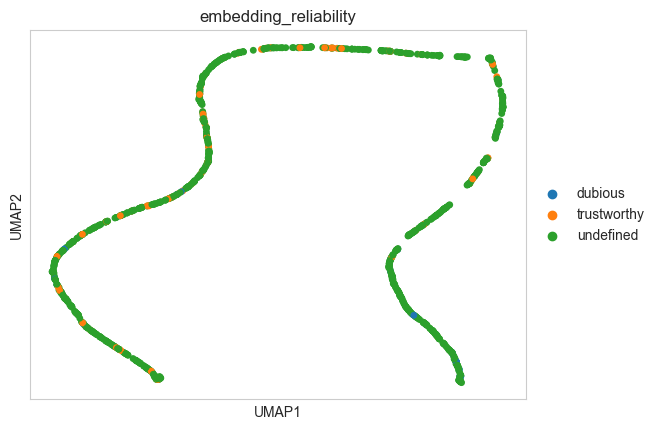

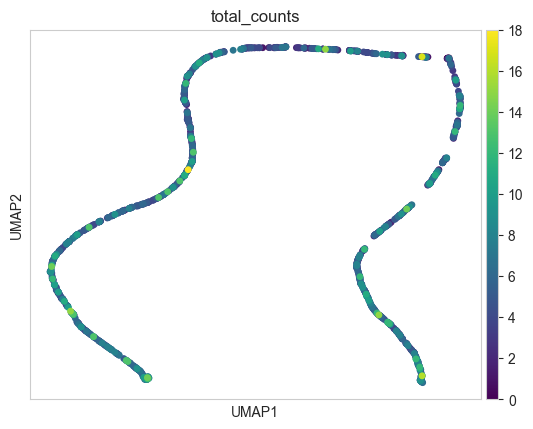

In [51]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [52]:
data_gene.write(data_path + "/data_gene_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [53]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

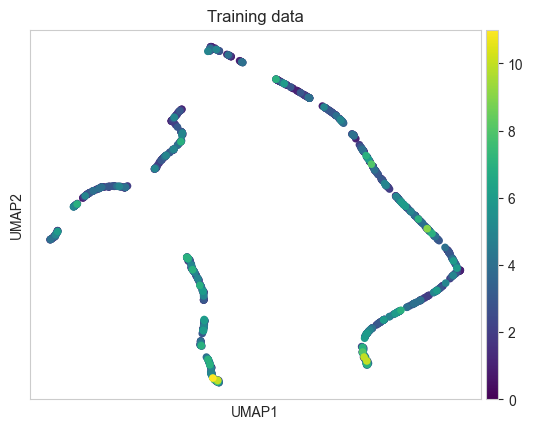

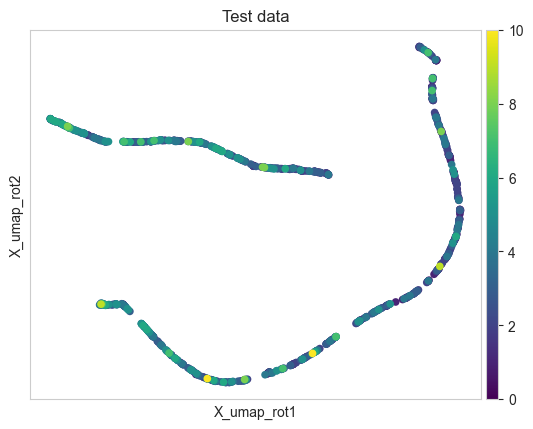

In [54]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [55]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

In [ ]:
# sc.pl.umap(data_train, color=[f"leiden_res{resolution}" for resolution in resolutions])
# plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

Modularities

In [ ]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

In [ ]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

In [ ]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [ ]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

In [ ]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

In [ ]:
data_gene.write(data_path + "/data_gene_processed.h5ad")

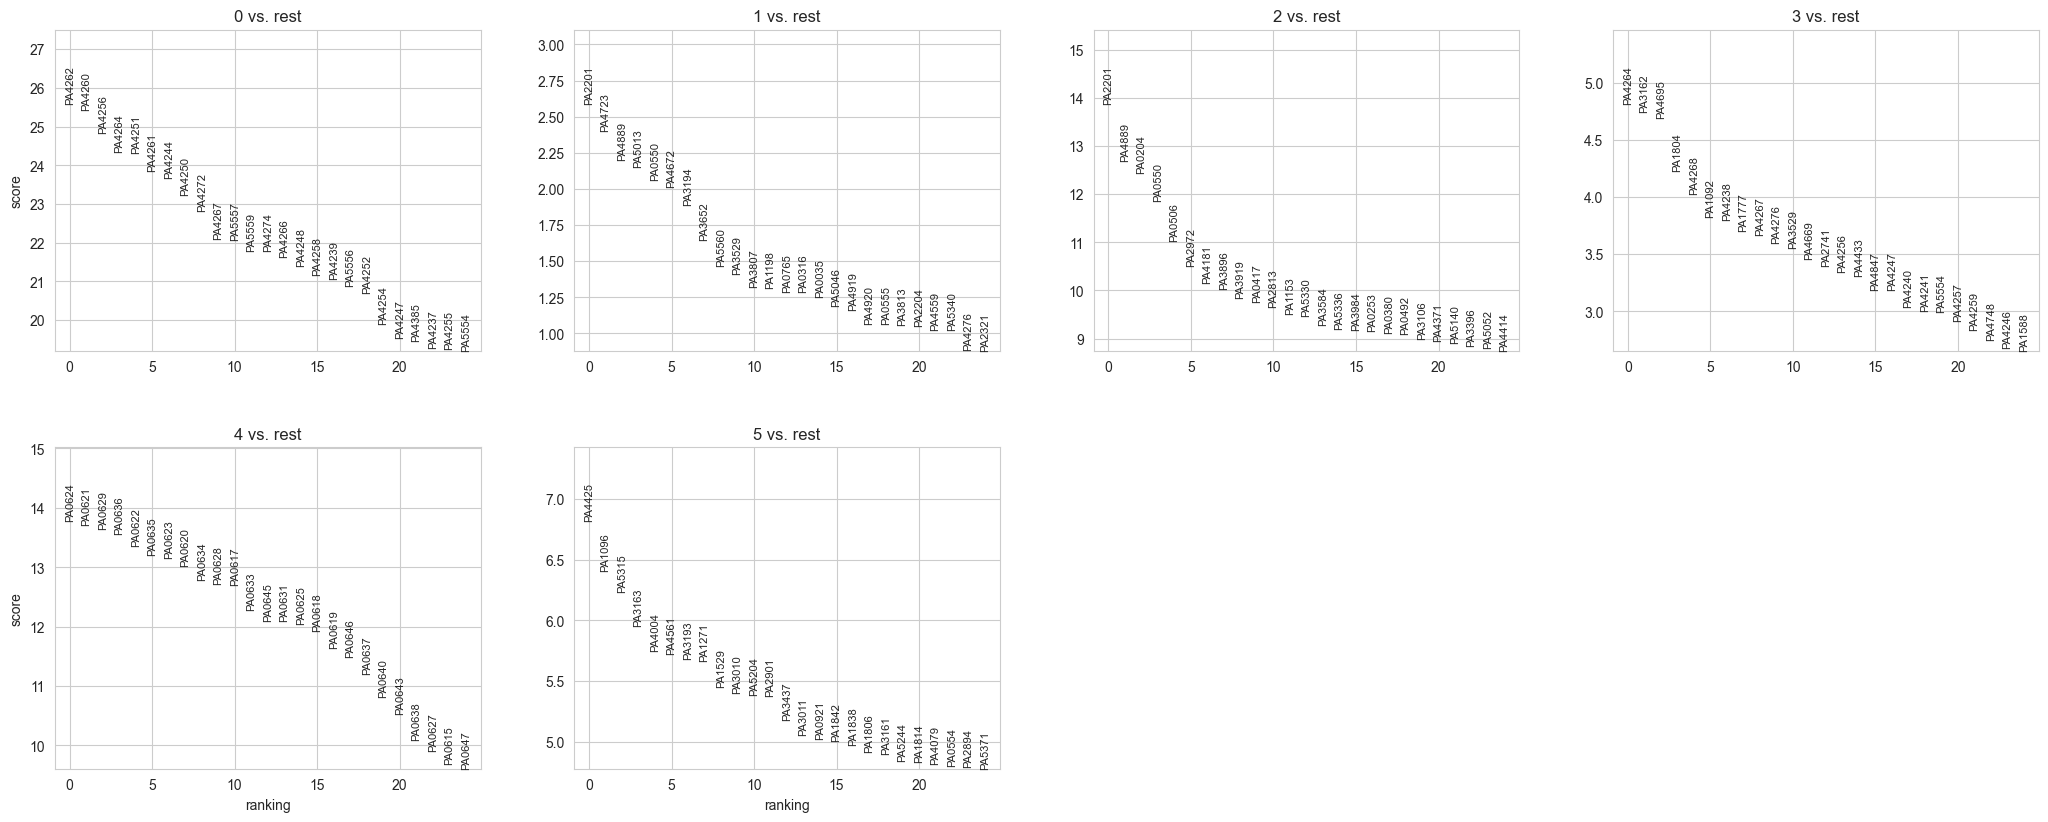

In [113]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [114]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

In [115]:
top_genes_3 = [x[3] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA4264', 'PA3162', 'PA4695', 'PA1804', 'PA4268', 'PA1092', 'PA4238', 'PA1777', 'PA4267', 'PA4276', 'PA3529', 'PA4669', 'PA2741', 'PA4256', 'PA4433', 'PA4847', 'PA4247', 'PA4240', 'PA4241', 'PA5554', 'PA4257', 'PA4259', 'PA4748', 'PA4246', 'PA1588']


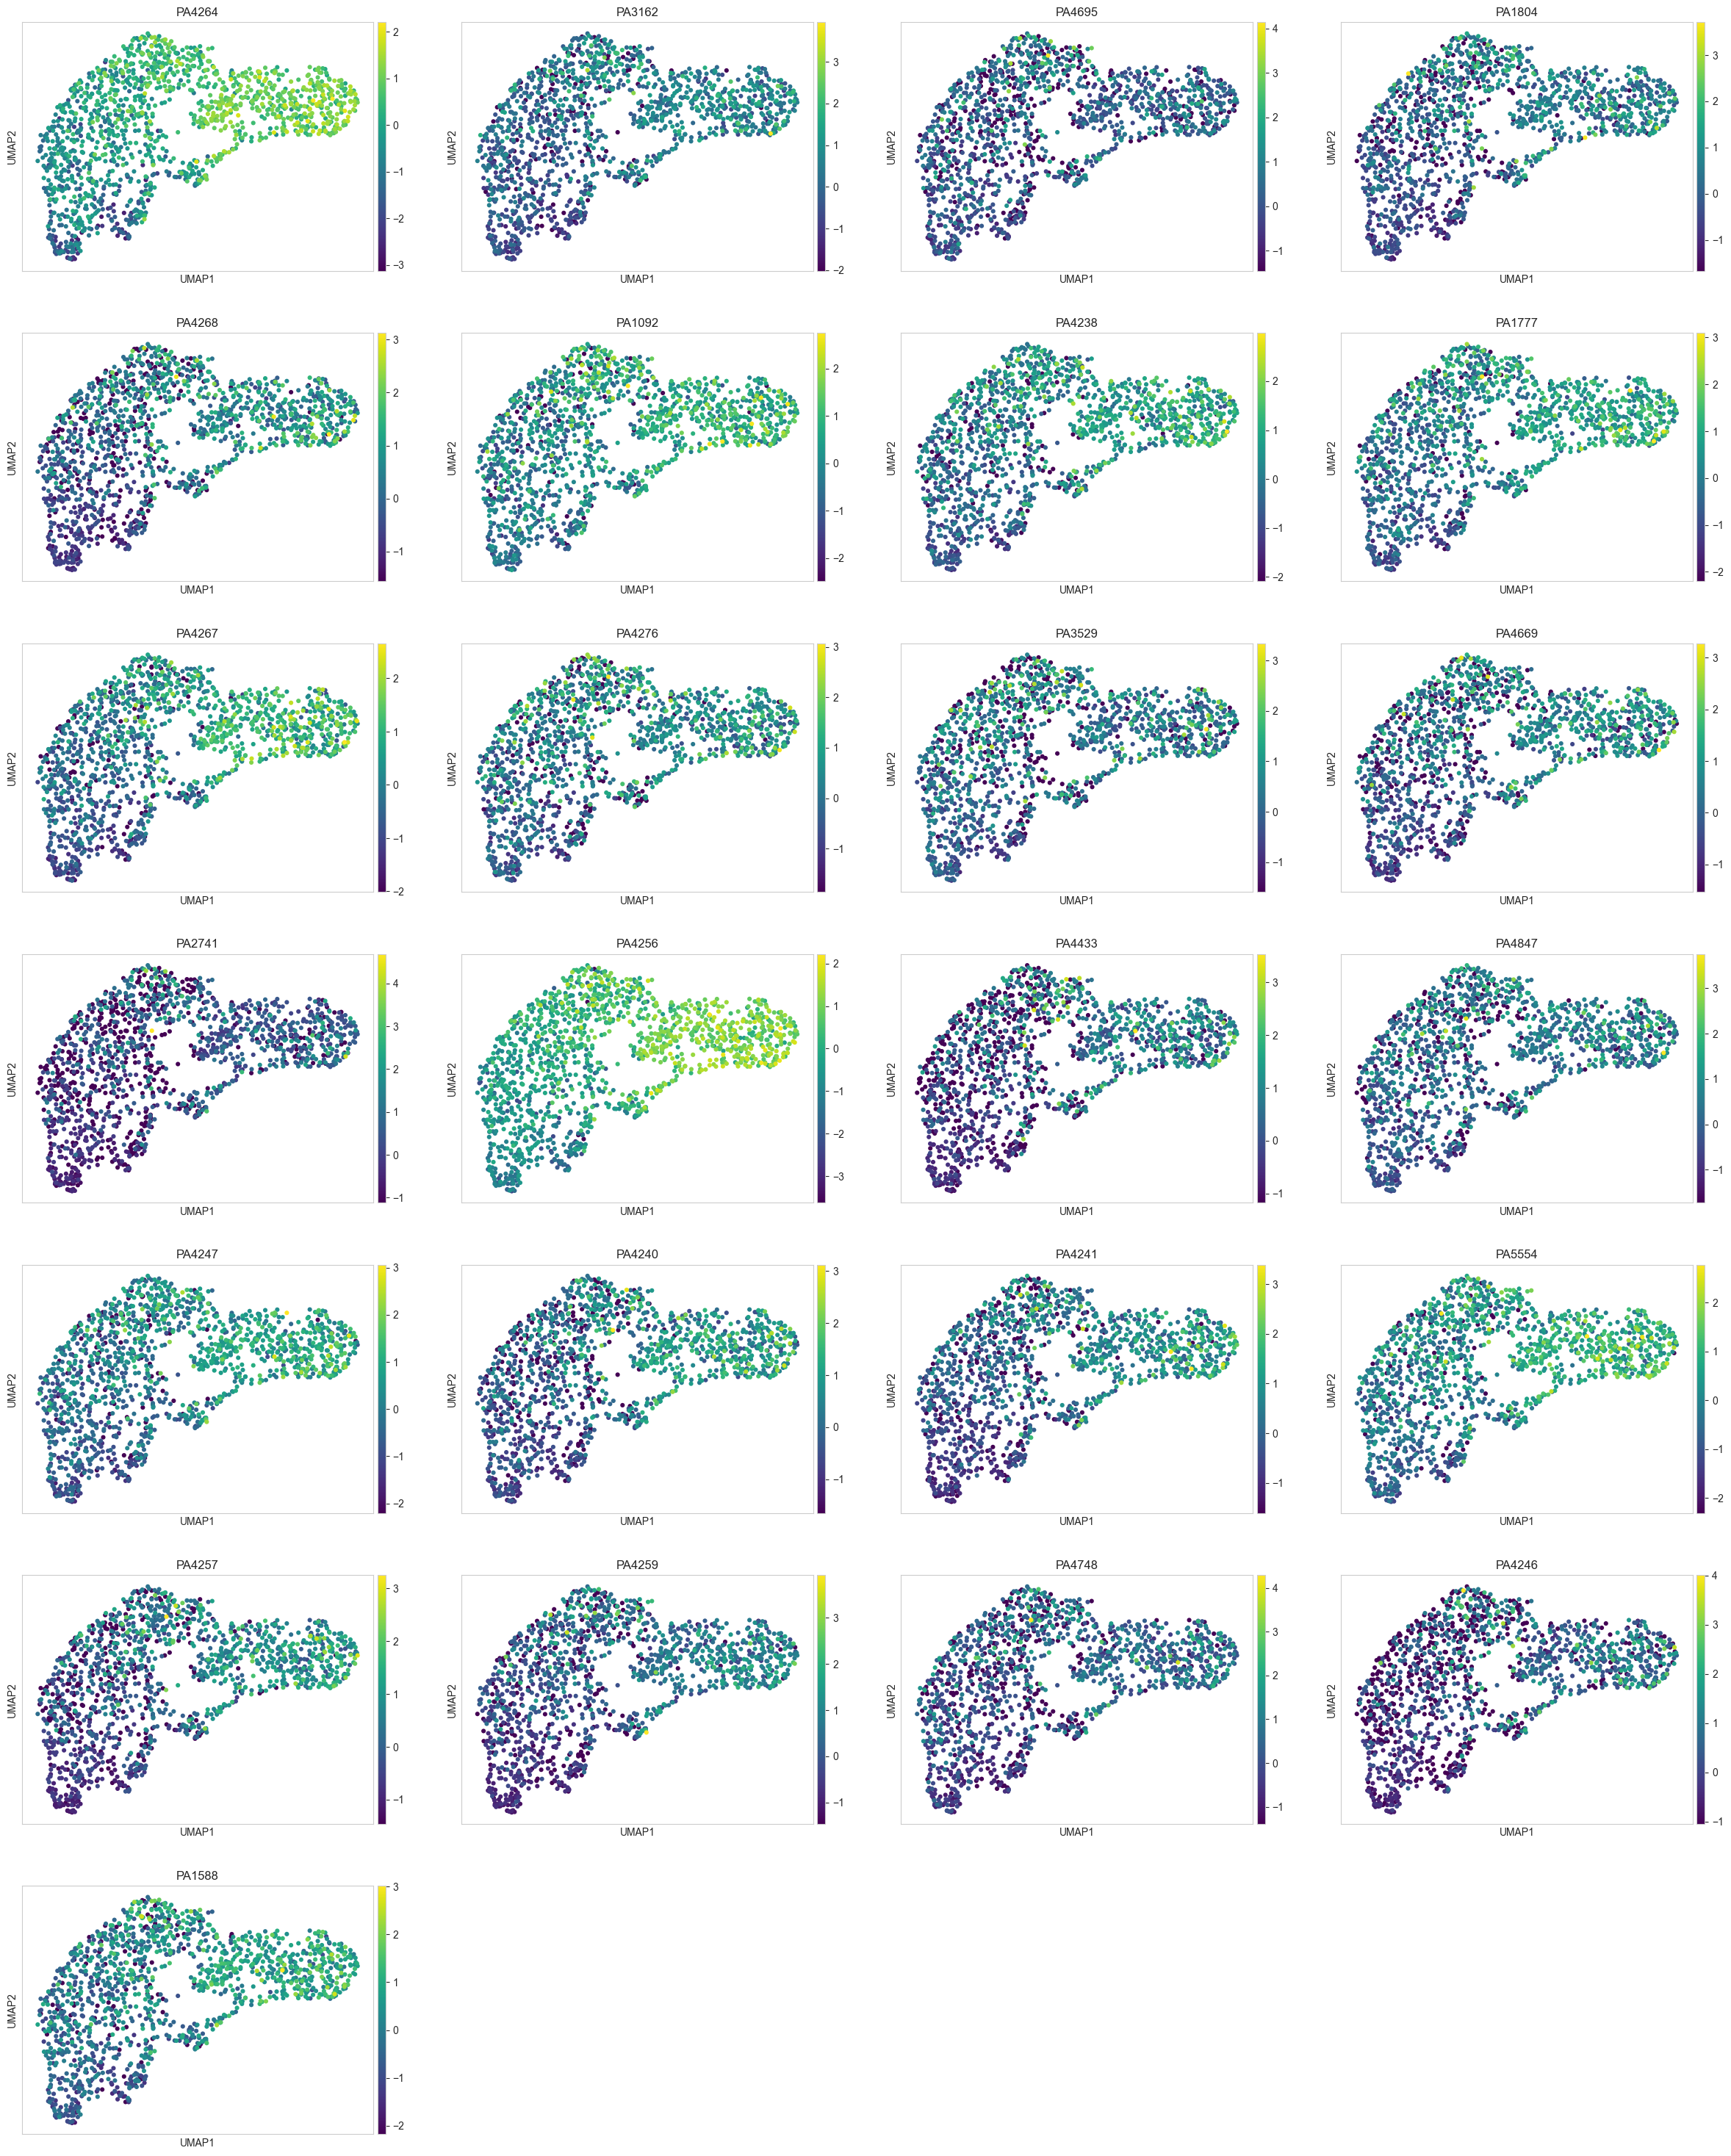

In [116]:
sc.pl.umap(data_gene, color=top_genes_3[:25], palette="tab20", cmap="viridis")

In [117]:
top_genes_4 = [x[4] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_4[:25])

['PA0624', 'PA0621', 'PA0629', 'PA0636', 'PA0622', 'PA0635', 'PA0623', 'PA0620', 'PA0634', 'PA0628', 'PA0617', 'PA0633', 'PA0645', 'PA0631', 'PA0625', 'PA0618', 'PA0619', 'PA0646', 'PA0637', 'PA0640', 'PA0643', 'PA0638', 'PA0627', 'PA0615', 'PA0647']


In [118]:
top_genes_5 = [x[5] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_5[:25])

['PA4425', 'PA1096', 'PA5315', 'PA3163', 'PA4004', 'PA4561', 'PA3193', 'PA1271', 'PA1529', 'PA3010', 'PA5204', 'PA2901', 'PA3437', 'PA3011', 'PA0921', 'PA1842', 'PA1838', 'PA1806', 'PA3161', 'PA5244', 'PA1814', 'PA4079', 'PA0554', 'PA2894', 'PA5371']


In [119]:
top_genes_2 = [x[2] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_2[:25])

['PA2201', 'PA4889', 'PA0204', 'PA0550', 'PA0506', 'PA2972', 'PA4181', 'PA3896', 'PA3919', 'PA0417', 'PA2813', 'PA1153', 'PA5330', 'PA3584', 'PA5336', 'PA3984', 'PA0253', 'PA0380', 'PA0492', 'PA3106', 'PA4371', 'PA5140', 'PA3396', 'PA5052', 'PA4414']
